# K-Means Clustering for Route Recommendations

**Purpose:** Cluster all routes into k groups (e.g., k=10) to enable "curveball" recommendations from different clusters.

**Goal:** 
- Find optimal k (number of clusters)
- Cluster routes by similarity
- Profile each cluster to enable manual labeling (e.g., 'long mountain ride', 'short city ride')
- Save model for production use

**Use Case:** When a user uploads a route, serve:
- 5 nearest neighbors (KNN) from same/similar characteristics
- 1 "curveball" from a different cluster

## 1. Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Load the engineered data
df = pd.read_csv("../../api_faf/app/Data_Engineered.csv")
print(f"✅ Loaded {len(df):,} routes")
print(f"   Columns: {df.shape[1]}")
print(f"\nFirst few rows:")
df.head()

✅ Loaded 24,766 routes
   Columns: 27

First few rows:


,id,name,distance_m,duration_s,ascent_m,descent_m,steps,turns,region,Cycleway,Turn_Density,on_road,off_road,Gravel_Tracks,Paved_Paths,Other,Unknown Surface,Paved_Road,Pedestrian,Unknown_Way,Cycle Track,Main Road,Steep Section,Moderate Section,Flat Section,Downhill Section,Steep Downhill Section
0,6101627,Ciclopedonale Lago Ghirla,1885.5,377.1,51.8,93.8,2,0,Alps,61.29,0.0,98.39,0.0,0.0,0.0,0.0,1.61,38.71,0.0,0.0,0.0,0.0,0.00,75.81,0.0,9.68,14.52
1,10187640,Tour du Léman - Étape 4,4138.4,827.6,164.5,173.5,2,0,Alps,0.00,0.0,100.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,100.0,0.00,77.12,0.0,21.19,1.69
2,12509770,La Madeleine Nord,24714.5,4942.9,2182.8,670.8,2,0,Alps,0.00,0.0,96.21,0.0,0.0,0.0,0.0,3.79,100.00,0.0,0.0,0.0,0.0,35.78,50.62,0.0,9.25,4.35
3,15361105,Unnamed route,984.9,197.0,14.5,21.5,2,0,Alps,0.00,0.0,100.00,0.0,0.0,0.0,0.0,0.00,100.00,0.0,0.0,0.0,0.0,0.00,0.00,100.0,0.00,0.00
4,15630528,Unnamed route,1662.8,332.5,31.1,9.1,2,0,Alps,0.00,0.0,100.00,0.0,0.0,0.0,0.0,0.00,100.00,0.0,0.0,0.0,0.0,0.00,100.00,0.0,0.00,0.00


In [3]:
# Check for missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print("⚠️  Missing values found:")
    print(missing[missing > 0])
else:
    print("✅ No missing values")

✅ No missing values


## 2. Prepare Features (Same as KNN Model)

Use the same scaling approach as the KNN model for consistency.

In [4]:
# Create feature matrix (exclude id, name, region)
X = df.drop(['id', 'name', 'region'], axis=1)
feature_cols = X.columns.tolist()

print(f"✅ Feature matrix created: {X.shape}")
print(f"\n📊 Features ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

✅ Feature matrix created: (24766, 24)

📊 Features (24):
   1. distance_m
   2. duration_s
   3. ascent_m
   4. descent_m
   5. steps
   6. turns
   7. Cycleway
   8. Turn_Density
   9. on_road
  10. off_road
  11. Gravel_Tracks
  12. Paved_Paths
  13. Other
  14. Unknown Surface
  15. Paved_Road
  16. Pedestrian
  17. Unknown_Way
  18. Cycle Track
  19. Main Road
  20. Steep Section
  21. Moderate Section
  22. Flat Section
  23. Downhill Section
  24. Steep Downhill Section


In [5]:
# Apply same scaling as KNN training
scaler = ColumnTransformer(transformers=[
    ('standard', StandardScaler(), [
        'distance_m', 'duration_s', 'ascent_m', 'descent_m',
        'Turn_Density', 'steps', 'turns'
    ]),
    ('minmax', MinMaxScaler(), [
        'Cycleway', 'on_road', 'off_road', 'Gravel_Tracks', 'Paved_Paths',
        'Other', 'Unknown Surface', 'Paved_Road', 'Pedestrian', 'Unknown_Way',
        'Cycle Track', 'Main Road', 'Steep Section', 'Moderate Section',
        'Flat Section', 'Downhill Section', 'Steep Downhill Section'
    ]),
], remainder='passthrough')

X_scaled = scaler.fit_transform(X)
print(f"✅ Features scaled: {X_scaled.shape}")
print(f"   StandardScaler: 7 features (distance, duration, elevation, turns)")
print(f"   MinMaxScaler: 17 features (surface types, gradients)")

✅ Features scaled: (24766, 24)
   StandardScaler: 7 features (distance, duration, elevation, turns)
   MinMaxScaler: 17 features (surface types, gradients)


## 3. K-Means Parameter Search

Test different values of k and initialization methods to find optimal clustering.

In [6]:
# Define parameter grid
k_values = range(3, 21)  # Test k from 3 to 20
init_methods = ['k-means++', 'random']  # Initialization strategies
n_init = 20  # Number of times to run k-means with different seeds

print(f"🔍 Parameter Search Configuration:")
print(f"   k values: {list(k_values)}")
print(f"   Init methods: {init_methods}")
print(f"   n_init (runs per config): {n_init}")
print(f"\n⏳ This will test {len(k_values) * len(init_methods)} configurations...")

🔍 Parameter Search Configuration:
   k values: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
   Init methods: ['k-means++', 'random']
   n_init (runs per config): 20

⏳ This will test 36 configurations...


### 3.1 Evaluation Metrics

We'll use multiple metrics to evaluate clustering quality:

1. **Inertia (Within-cluster sum of squares)**: Lower is better. Shows how tight clusters are.
2. **Silhouette Score**: Range [-1, 1]. Higher is better. Measures how similar points are to their own cluster vs other clusters.
3. **Davies-Bouldin Index**: Lower is better. Measures average similarity between clusters.
4. **Calinski-Harabasz Score**: Higher is better. Ratio of between-cluster to within-cluster dispersion.

In [7]:
# Run parameter search
results = []

for k in k_values:
    for init in init_methods:
        print(f"Testing k={k:2d}, init='{init}'...", end=' ')

        # Fit k-means
        kmeans = KMeans(
            n_clusters=k,
            init=init,
            n_init=n_init,
            max_iter=300,
            random_state=42
        )
        labels = kmeans.fit_predict(X_scaled)

        # Calculate metrics
        inertia = kmeans.inertia_
        silhouette = silhouette_score(X_scaled, labels, sample_size=10000)  # Sample for speed
        davies_bouldin = davies_bouldin_score(X_scaled, labels)
        calinski = calinski_harabasz_score(X_scaled, labels)

        results.append({
            'k': k,
            'init': init,
            'inertia': inertia,
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'calinski_harabasz': calinski
        })

        print(f"✓ Silhouette: {silhouette:.4f}")

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(f"\n✅ Parameter search complete! Tested {len(results_df)} configurations.")

Testing k= 3, init='k-means++'... ✓ Silhouette: 0.6880
Testing k= 3, init='random'... ✓ Silhouette: 0.6935
Testing k= 4, init='k-means++'... ✓ Silhouette: 0.6989
Testing k= 4, init='random'... ✓ Silhouette: 0.6919
Testing k= 5, init='k-means++'... ✓ Silhouette: 0.5911
Testing k= 5, init='random'... ✓ Silhouette: 0.1984
Testing k= 6, init='k-means++'... ✓ Silhouette: 0.5614
Testing k= 6, init='random'... ✓ Silhouette: 0.2075
Testing k= 7, init='k-means++'... ✓ Silhouette: 0.2062
Testing k= 7, init='random'... ✓ Silhouette: 0.2066
Testing k= 8, init='k-means++'... ✓ Silhouette: 0.2124
Testing k= 8, init='random'... ✓ Silhouette: 0.2308
Testing k= 9, init='k-means++'... ✓ Silhouette: 0.2195
Testing k= 9, init='random'... ✓ Silhouette: 0.1981
Testing k=10, init='k-means++'... ✓ Silhouette: 0.2199
Testing k=10, init='random'... ✓ Silhouette: 0.1970
Testing k=11, init='k-means++'... ✓ Silhouette: 0.2017
Testing k=11, init='random'... ✓ Silhouette: 0.2081
Testing k=12, init='k-means++'... ✓ S

In [8]:
# Display results sorted by different metrics
print("=" * 100)
print("TOP 10 CONFIGURATIONS BY SILHOUETTE SCORE (higher is better)")
print("=" * 100)
print(results_df.sort_values('silhouette', ascending=False).head(10))

print("\n" + "=" * 100)
print("TOP 10 CONFIGURATIONS BY DAVIES-BOULDIN INDEX (lower is better)")
print("=" * 100)
print(results_df.sort_values('davies_bouldin', ascending=True).head(10))

print("\n" + "=" * 100)
print("TOP 10 CONFIGURATIONS BY CALINSKI-HARABASZ SCORE (higher is better)")
print("=" * 100)
print(results_df.sort_values('calinski_harabasz', ascending=False).head(10))

TOP 10 CONFIGURATIONS BY SILHOUETTE SCORE (higher is better)
     k       init        inertia  silhouette  davies_bouldin  \
2    4  k-means++   94036.248020    0.698880        0.766716   
1    3     random  107026.341734    0.693477        0.794498   
3    4     random   94036.251628    0.691918        0.766784   
0    3  k-means++  107021.077530    0.688037        0.785896   
4    5  k-means++   82427.293939    0.591090        0.848075   
6    6  k-means++   75030.742023    0.561395        0.894181   
35  20     random   38971.149138    0.275530        1.226084   
31  18     random   41422.672375    0.265234        1.175751   
29  17     random   42574.922333    0.261554        1.141629   
34  20  k-means++   33912.806323    0.257982        1.016042   

    calinski_harabasz  
2         9519.352222  
1        11043.670291  
3         9519.351540  
0        11044.822540  
4         9016.535070  
6         8412.157612  
35        5464.770487  
31        5660.518902  
29        5809.903

## 4. Visualize Results

Create plots to help identify the optimal k value.

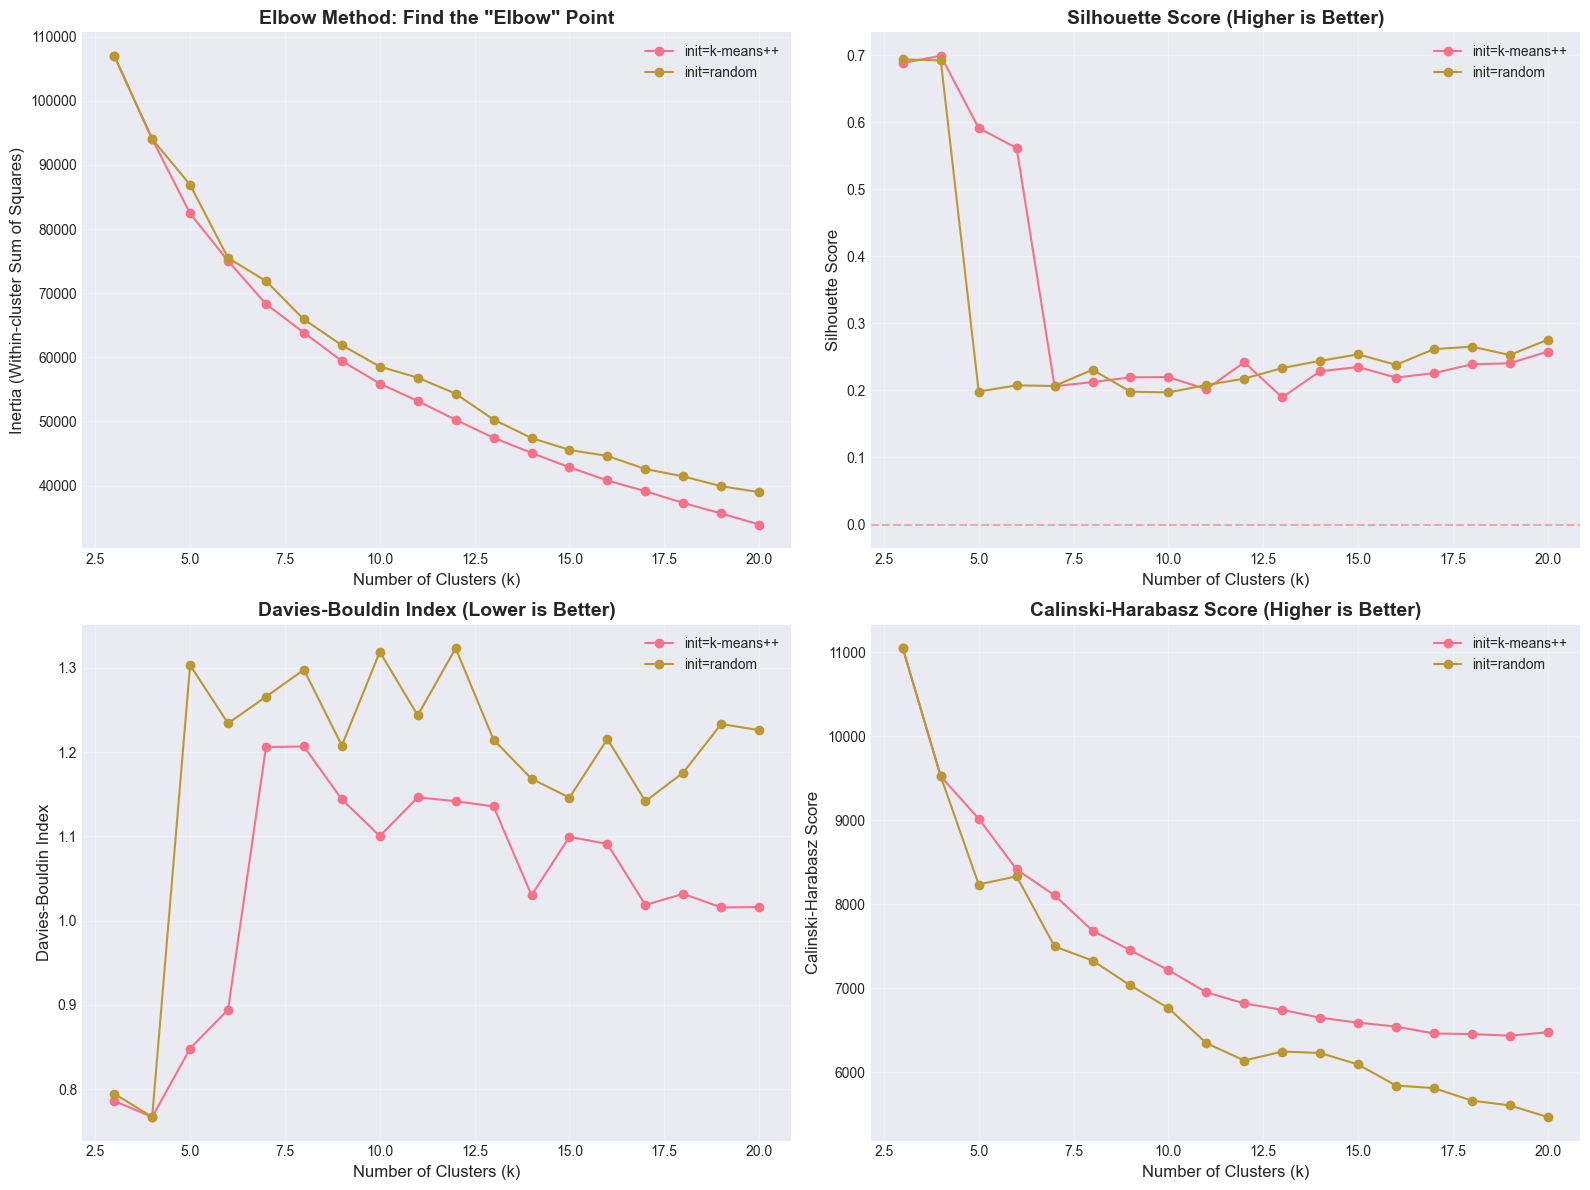

✅ Plots saved as 'kmeans_evaluation_metrics.png'


In [10]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Elbow Method (Inertia)
for init in init_methods:
    data = results_df[results_df['init'] == init]
    axes[0, 0].plot(data['k'], data['inertia'], marker='o', label=f"init={init}")
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia (Within-cluster Sum of Squares)', fontsize=12)
axes[0, 0].set_title('Elbow Method: Find the "Elbow" Point', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Silhouette Score
for init in init_methods:
    data = results_df[results_df['init'] == init]
    axes[0, 1].plot(data['k'], data['silhouette'], marker='o', label=f"init={init}")
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.3)

# Plot 3: Davies-Bouldin Index
for init in init_methods:
    data = results_df[results_df['init'] == init]
    axes[1, 0].plot(data['k'], data['davies_bouldin'], marker='o', label=f"init={init}")
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1, 0].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Calinski-Harabasz Score
for init in init_methods:
    data = results_df[results_df['init'] == init]
    axes[1, 1].plot(data['k'], data['calinski_harabasz'], marker='o', label=f"init={init}")
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 1].set_title('Calinski-Harabasz Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kmeans_evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plots saved as 'kmeans_evaluation_metrics.png'")

In [11]:
# Create a combined score ranking
# Normalize metrics to [0, 1] scale and combine
results_norm = results_df.copy()

# Normalize: higher silhouette is better, lower davies_bouldin is better, higher calinski is better
results_norm['silhouette_norm'] = (results_norm['silhouette'] - results_norm['silhouette'].min()) / \
                                   (results_norm['silhouette'].max() - results_norm['silhouette'].min())

results_norm['davies_bouldin_norm'] = 1 - ((results_norm['davies_bouldin'] - results_norm['davies_bouldin'].min()) / \
                                             (results_norm['davies_bouldin'].max() - results_norm['davies_bouldin'].min()))

results_norm['calinski_norm'] = (results_norm['calinski_harabasz'] - results_norm['calinski_harabasz'].min()) / \
                                 (results_norm['calinski_harabasz'].max() - results_norm['calinski_harabasz'].min())

# Combined score (equal weights)
results_norm['combined_score'] = (results_norm['silhouette_norm'] +
                                   results_norm['davies_bouldin_norm'] +
                                   results_norm['calinski_norm']) / 3

print("=" * 100)
print("TOP 10 CONFIGURATIONS BY COMBINED SCORE")
print("=" * 100)
print(results_norm.sort_values('combined_score', ascending=False)[[
    'k', 'init', 'combined_score', 'silhouette', 'davies_bouldin', 'calinski_harabasz'
]].head(10))

TOP 10 CONFIGURATIONS BY COMBINED SCORE
     k       init  combined_score  silhouette  davies_bouldin  \
0    3  k-means++        0.981415    0.688037        0.785896   
1    3     random        0.979756    0.693477        0.794498   
2    4  k-means++        0.908874    0.698880        0.766716   
3    4     random        0.904276    0.691918        0.766784   
4    5  k-means++        0.759556    0.591090        0.848075   
6    6  k-means++        0.676402    0.561395        0.894181   
34  20  k-means++        0.289045    0.257982        1.016042   
32  19  k-means++        0.275423    0.240443        1.015584   
22  14  k-means++        0.271737    0.228559        1.030033   
30  18  k-means++        0.265883    0.238939        1.031732   

    calinski_harabasz  
0        11044.822540  
1        11043.670291  
2         9519.352222  
3         9519.351540  
4         9016.535070  
6         8412.157612  
34        6474.149649  
32        6433.698445  
22        6647.070402  
30  

## 5. Select Optimal K and Fit Final Model

Based on the evaluation metrics above, select the optimal k value.

In [12]:
# Get best configuration
best_config = results_norm.sort_values('combined_score', ascending=False).iloc[0]
optimal_k = int(best_config['k'])
optimal_init = best_config['init']

print(f"🏆 RECOMMENDED CONFIGURATION:")
print(f"   k = {optimal_k}")
print(f"   init = '{optimal_init}'")
print(f"   Combined Score = {best_config['combined_score']:.4f}")
print(f"\n📊 Metrics:")
print(f"   Silhouette Score: {best_config['silhouette']:.4f}")
print(f"   Davies-Bouldin Index: {best_config['davies_bouldin']:.4f}")
print(f"   Calinski-Harabasz Score: {best_config['calinski_harabasz']:.2f}")

🏆 RECOMMENDED CONFIGURATION:
   k = 3
   init = 'k-means++'
   Combined Score = 0.9814

📊 Metrics:
   Silhouette Score: 0.6880
   Davies-Bouldin Index: 0.7859
   Calinski-Harabasz Score: 11044.82


In [17]:
# Allow manual override if desired
# OVERRIDE: Set to None to use recommended k, or set to desired value (e.g., 10)
MANUAL_K = 10  # Change to 10 if you want to force k=10 for easier labeling

if MANUAL_K is not None:
    final_k = MANUAL_K
    print(f"⚠️  MANUAL OVERRIDE: Using k = {final_k} instead of recommended k = {optimal_k}")
else:
    final_k = optimal_k
    print(f"✅ Using recommended k = {final_k}")

⚠️  MANUAL OVERRIDE: Using k = 10 instead of recommended k = 3


In [18]:
# Fit final k-means model
print(f"\n⏳ Fitting final k-means model with k={final_k}...")

kmeans_final = KMeans(
    n_clusters=final_k,
    init='k-means++',  # Generally more reliable
    n_init=50,  # More runs for final model
    max_iter=300,
    random_state=42
)

cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['cluster'] = cluster_labels

print(f"✅ K-means clustering complete!")
print(f"\n📊 Cluster distribution:")
print(df['cluster'].value_counts().sort_index())


⏳ Fitting final k-means model with k=10...
✅ K-means clustering complete!

📊 Cluster distribution:
cluster
0     9490
1      185
2    12440
3        5
4     1560
5      663
6      326
7       28
8       65
9        4
Name: count, dtype: int64


## 6. Cluster Profiling

Analyze each cluster to understand its characteristics and enable manual labeling.

In [21]:
# Calculate cluster statistics for key features
key_features = ['distance_m', 'ascent_m', 'duration_s', 'Turn_Density',
                'on_road', 'off_road', 'Flat Section', 'Steep Section']

cluster_profiles = df.groupby('cluster')[key_features].agg(['mean', 'median', 'std']).round(2)

print("=" * 120)
print("CLUSTER PROFILES")
print("=" * 120)
print(cluster_profiles)

CLUSTER PROFILES
        distance_m                        ascent_m                     \
              mean     median        std      mean    median      std   
cluster                                                                 
0          2334.35     816.85    3628.96     70.72     11.00   166.47   
1        127965.38  115647.90   48729.59   1392.21   1283.30   799.24   
2          2997.26    1531.75    4107.31     21.83      8.30    35.10   
3        645944.70  639431.40  116836.02   6498.52   4649.80  3864.21   
4         33041.77   29471.55   17462.63    417.36    316.05   316.52   
5           172.07     105.40     181.79      2.05      1.00     3.79   
6         56686.93   54207.50   22154.42   1704.40   1538.90   715.83   
7        354258.47  327848.60  135117.18   5107.66   4958.60  2006.66   
8            27.03      21.60      16.83      0.32      0.00     0.93   
9        748556.85  663424.05  242967.45  18189.82  17102.25  4576.56   

        duration_s               

In [23]:
# Create detailed cluster summary
for cluster_id in range(final_k):
    cluster_data = df[df['cluster'] == cluster_id]

    print("\n" + "=" * 100)
    print(f"CLUSTER {cluster_id} - {len(cluster_data):,} routes ({len(cluster_data)/len(df)*100:.1f}%)")
    print("=" * 100)

    # Distance characteristics
    print(f"\n📏 Distance:")
    print(f"   Mean: {cluster_data['distance_m'].mean()/1000:.1f} km")
    print(f"   Median: {cluster_data['distance_m'].median()/1000:.1f} km")
    print(f"   Range: {cluster_data['distance_m'].min()/1000:.1f} - {cluster_data['distance_m'].max()/1000:.1f} km")

    # Elevation characteristics
    print(f"\n⛰️  Elevation:")
    print(f"   Mean ascent: {cluster_data['ascent_m'].mean():.0f} m")
    print(f"   Median ascent: {cluster_data['ascent_m'].median():.0f} m")

    # Surface type (dominant)
    print(f"\n🛣️  Surface:")
    print(f"   On-road: {cluster_data['on_road'].mean():.1f}%")
    print(f"   Off-road: {cluster_data['off_road'].mean():.1f}%")
    print(f"   Paved Road: {cluster_data['Paved_Road'].mean():.1f}%")
    print(f"   Gravel: {cluster_data['Gravel_Tracks'].mean():.1f}%")

    # Gradient profile
    print(f"\n📐 Gradient:")
    print(f"   Flat: {cluster_data['Flat Section'].mean():.1f}%")
    print(f"   Moderate: {cluster_data['Moderate Section'].mean():.1f}%")
    print(f"   Steep: {cluster_data['Steep Section'].mean():.1f}%")

    # Example routes
    print(f"\n📋 Sample routes:")
    sample_routes = cluster_data.head(5)[['id', 'name', 'distance_m', 'ascent_m']]
    for idx, route in sample_routes.iterrows():
        print(f"   • {route['name'][:60]} (ID: {route['id']}, {route['distance_m']/1000:.1f}km, {route['ascent_m']:.0f}m ascent)")


CLUSTER 0 - 9,490 routes (38.3%)

📏 Distance:
   Mean: 2.3 km
   Median: 0.8 km
   Range: 0.0 - 31.8 km

⛰️  Elevation:
   Mean ascent: 71 m
   Median ascent: 11 m

🛣️  Surface:
   On-road: 61.9%
   Off-road: 1.2%
   Paved Road: 67.0%
   Gravel: 3.5%

📐 Gradient:
   Flat: 3.3%
   Moderate: 41.9%
   Steep: 3.7%

📋 Sample routes:
   • Ciclopedonale Lago Ghirla (ID: 6101627, 1.9km, 52m ascent)
   • Tour du Léman - Étape 4 (ID: 10187640, 4.1km, 164m ascent)
   • Unnamed route (ID: 15630528, 1.7km, 31m ascent)
   • Unnamed route (ID: 15630533, 3.7km, 86m ascent)
   • Unnamed route (ID: 15630538, 4.9km, 87m ascent)

CLUSTER 1 - 185 routes (0.7%)

📏 Distance:
   Mean: 128.0 km
   Median: 115.6 km
   Range: 57.4 - 310.5 km

⛰️  Elevation:
   Mean ascent: 1392 m
   Median ascent: 1283 m

🛣️  Surface:
   On-road: 63.2%
   Off-road: 0.8%
   Paved Road: 58.7%
   Gravel: 4.8%

📐 Gradient:
   Flat: 70.9%
   Moderate: 12.5%
   Steep: 1.1%

📋 Sample routes:
   • Ciclovia Canale Cavour (ID: 17921159, 

## 7. Visualize Cluster Characteristics

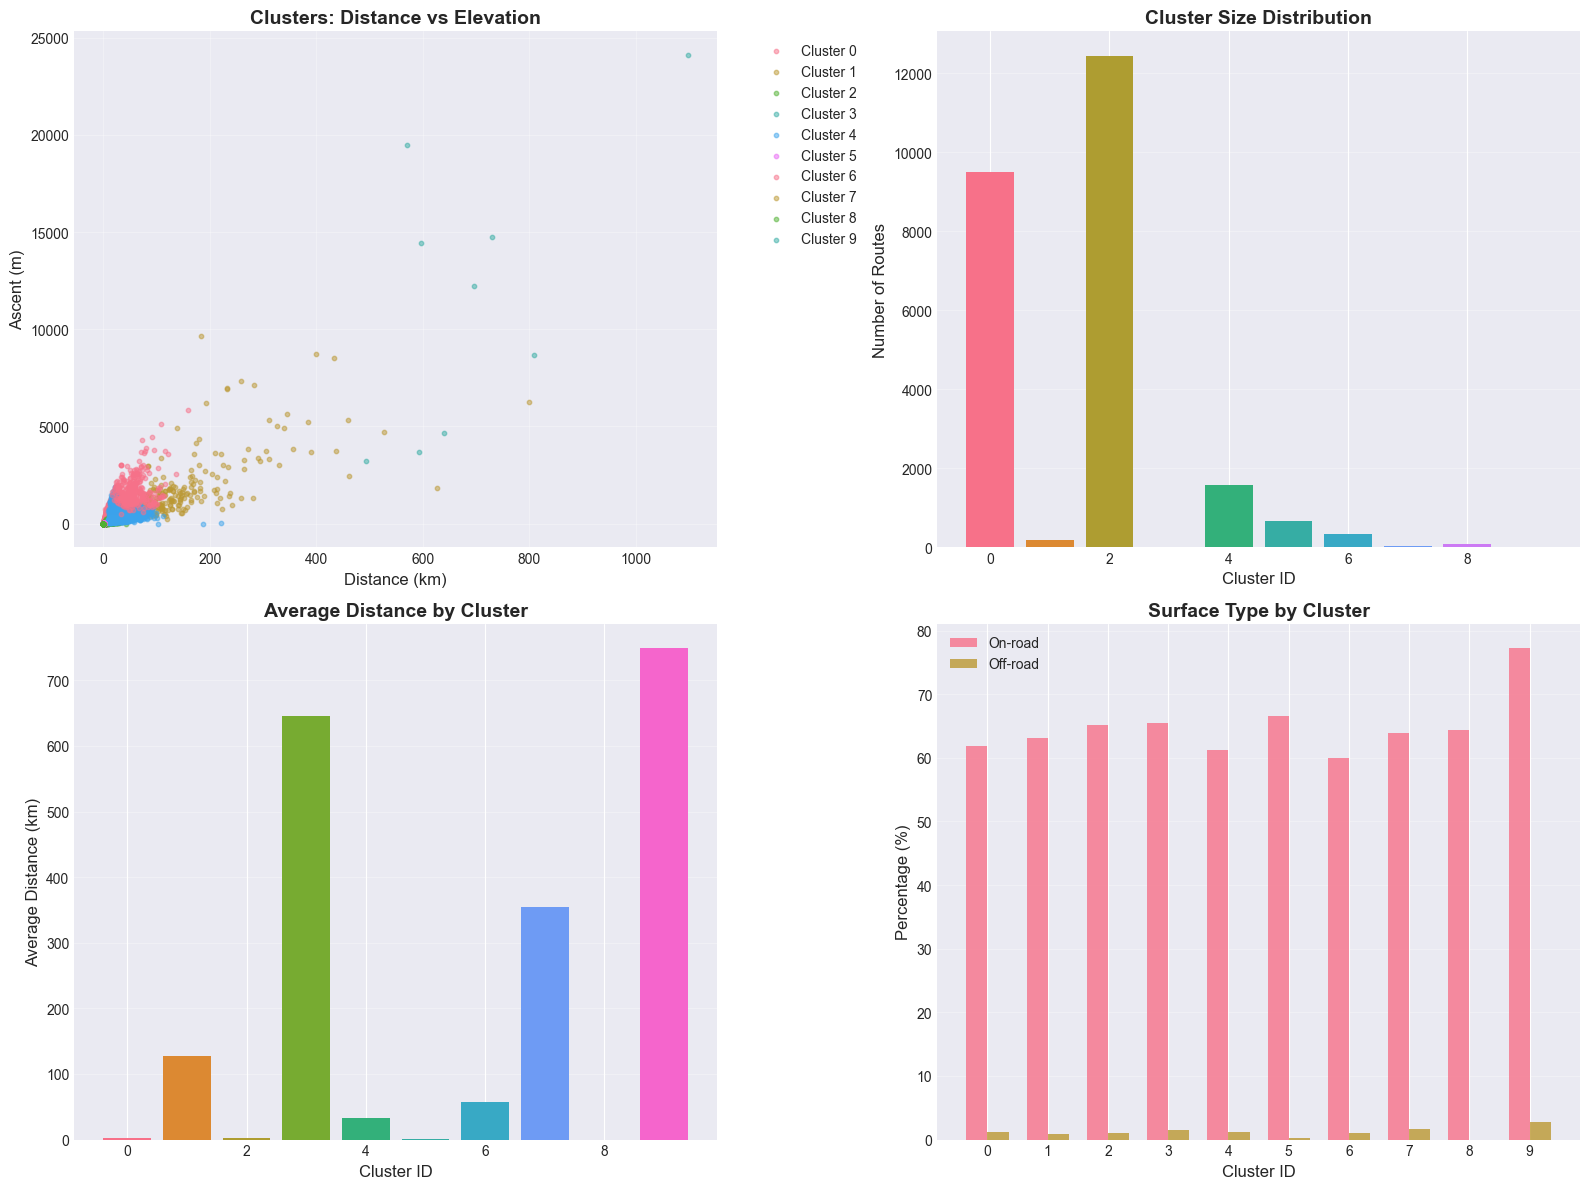

✅ Cluster visualization saved as 'cluster_characteristics.png'


In [24]:
# Create cluster visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Distance vs Ascent by Cluster
for cluster_id in range(final_k):
    cluster_data = df[df['cluster'] == cluster_id]
    axes[0, 0].scatter(
        cluster_data['distance_m'] / 1000,
        cluster_data['ascent_m'],
        label=f'Cluster {cluster_id}',
        alpha=0.5,
        s=10
    )
axes[0, 0].set_xlabel('Distance (km)', fontsize=12)
axes[0, 0].set_ylabel('Ascent (m)', fontsize=12)
axes[0, 0].set_title('Clusters: Distance vs Elevation', fontsize=14, fontweight='bold')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Cluster size distribution
cluster_sizes = df['cluster'].value_counts().sort_index()
axes[0, 1].bar(cluster_sizes.index, cluster_sizes.values, color=sns.color_palette("husl", final_k))
axes[0, 1].set_xlabel('Cluster ID', fontsize=12)
axes[0, 1].set_ylabel('Number of Routes', fontsize=12)
axes[0, 1].set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Average distance by cluster
avg_distance = df.groupby('cluster')['distance_m'].mean() / 1000
axes[1, 0].bar(avg_distance.index, avg_distance.values, color=sns.color_palette("husl", final_k))
axes[1, 0].set_xlabel('Cluster ID', fontsize=12)
axes[1, 0].set_ylabel('Average Distance (km)', fontsize=12)
axes[1, 0].set_title('Average Distance by Cluster', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: On-road vs Off-road by cluster
surface_data = df.groupby('cluster')[['on_road', 'off_road']].mean()
x = np.arange(final_k)
width = 0.35
axes[1, 1].bar(x - width/2, surface_data['on_road'], width, label='On-road', alpha=0.8)
axes[1, 1].bar(x + width/2, surface_data['off_road'], width, label='Off-road', alpha=0.8)
axes[1, 1].set_xlabel('Cluster ID', fontsize=12)
axes[1, 1].set_ylabel('Percentage (%)', fontsize=12)
axes[1, 1].set_title('Surface Type by Cluster', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('cluster_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Cluster visualization saved as 'cluster_characteristics.png'")

## 8. Save Model and Cluster Labels

Save the trained k-means model for production use.

In [25]:
# Save k-means model
joblib.dump(kmeans_final, 'kmeans.pkl')
print(f"✅ K-means model saved as 'kmeans.pkl'")
print(f"   Clusters: {final_k}")
print(f"   Inertia: {kmeans_final.inertia_:.2f}")

# Save cluster-labeled data
df.to_csv('Data_Engineered_with_clusters.csv', index=False)
print(f"\n✅ Data with cluster labels saved as 'Data_Engineered_with_clusters.csv'")

# Save cluster profiles for reference
cluster_profiles.to_csv('cluster_profiles.csv')
print(f"✅ Cluster profiles saved as 'cluster_profiles.csv'")

✅ K-means model saved as 'kmeans.pkl'
   Clusters: 10
   Inertia: 55896.93

✅ Data with cluster labels saved as 'Data_Engineered_with_clusters.csv'
✅ Cluster profiles saved as 'cluster_profiles.csv'


## 9. Next Steps: Manual Labeling

Based on the cluster profiles above, manually assign descriptive labels to each cluster.

**Example labels:**
- Cluster 0: "Short flat city rides"
- Cluster 1: "Long mountain climbs"
- Cluster 2: "Moderate suburban routes"
- etc.

Create a mapping dictionary that can be used in production:

```python
CLUSTER_LABELS = {
    0: "Short flat city rides",
    1: "Long mountain climbs",
    # ... add more
}
```

**For curveball recommendations:**
1. User uploads GPX → extract features
2. Predict cluster: `user_cluster = kmeans.predict(scaled_features)`
3. Get 5 KNN recommendations (existing flow)
4. Get 1 curveball from different cluster: 
   - Filter routes where `cluster != user_cluster`
   - Find nearest route from that filtered set

## Summary

**Outputs:**
- `kmeans.pkl`: Trained k-means model
- `Data_Engineered_with_clusters.csv`: Full dataset with cluster labels
- `cluster_profiles.csv`: Statistical profiles of each cluster
- `kmeans_evaluation_metrics.png`: Metric comparison plots
- `cluster_characteristics.png`: Cluster visualization plots

**Files to deploy:**
- `kmeans.pkl` → Copy to `cycle_more/api_faf/app/`
- Cluster labels dictionary → Add to service code